# Change-Point Detection in Business Cycles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykalman import KalmanFilter
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import jarque_bera
from scipy.signal import find_peaks
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from sklearn.preprocessing import StandardScaler
import stumpy


In [2]:
# These are exchange rate data's, indexed, not actual values
neer_data = pd.read_excel('../data/processed_data/georgia_neer_data_cleaned_processed.xlsx')
reer_data = pd.read_excel('../data/processed_data/georgia_reer_data_cleaned_processed.xlsx')
# Date is in the format of MM-YYYY, must be converted to YYYY-MM-DD, where day is the first day of the month
neer_data['Date'] = pd.to_datetime(neer_data['Date'])
reer_data['Date'] = pd.to_datetime(reer_data['Date'])

# This is GDP data
gdp_data = pd.read_excel('../data/processed_data/georgia_monthly_gdp_chow_lin.xlsx')

# Merge NEER and REER data with GDP data
gdp_data = gdp_data.merge(neer_data, on='Date', how='left')
gdp_data = gdp_data.merge(reer_data, on='Date', how='left')

/var/folders/50/97r9rj4j6s9f_0_j75x32sxr0000gn/T/ipykernel_19041/2597797848.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  neer_data['Date'] = pd.to_datetime(neer_data['Date'])
/var/folders/50/97r9rj4j6s9f_0_j75x32sxr0000gn/T/ipykernel_19041/2597797848.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reer_data['Date'] = pd.to_datetime(reer_data['Date'])


 NEER (Nominal Effective Exchange Rate) and REER (Real Effective Exchange Rate) are indices that measure a country's currency value against a group of other currencies.

 The main difference between them is that NEER does not adjust for inflation, while REER does. This means NEER gives a basic measure of currency strength, whereas REER provides a more nuanced view by considering inflation differences, offering insights into a country's trade competitiveness.

 These indices are valuable for analyzing business cycles as they shed light on economic conditions impacting trade balance and overall economic health. By examining NEER and REER, economists and policymakers can evaluate how exchange rate changes affect economic growth, inflation, and trade competitiveness.
 This understanding is crucial for making informed decisions about monetary policy, trade agreements, and economic forecasts, which are essential for maintaining and fostering sustainable economic growth.

In [3]:
gdp_data

,Date,YoY Growth (%),Inflation_Rate,Real_GDP_Growth,q_str,GDP_at_market_prices,GDP per capita in GEL,"GDP per capita, USD",GDP in mil. USD,GDP_at_market_prices_monthly,GDP per capita in GEL_monthly,"GDP per capita, USD_monthly",GDP in mil. USD_monthly,NEER (Dec-2010=100),Real Effective Exchange Rate - Index (Dec-10=100),GEL/USD Real Exchange Rate - Index (Dec-10=100),GEL/EUR Real Exchange Rate - Index (Dec-10=100),GEL/TRY Real Exchange Rate - Index (Dec-10=100),GEL/RUB Real Exchange Rate - Index (Dec-10=100)
0,2011-01-01,9.6,2.0537,7.394440,2011Q1,5420.832044,1443.076775,819.517640,3078.469255,1809.399484,481.841744,264.603425,993.830608,98.445895,99.790539,99.720145,99.759842,102.612835,95.450989
1,2011-02-01,4.4,2.8186,1.538049,2011Q1,5420.832044,1443.076775,819.517640,3078.469255,1731.745438,460.888141,264.739568,994.565127,99.346752,102.541156,103.170221,101.269449,108.108247,95.835017
2,2011-03-01,3.7,-0.0218,3.722612,2011Q1,5420.832044,1443.076775,819.517640,3078.469255,1879.687122,500.346890,290.174647,1090.073520,102.133186,104.569463,105.961545,100.980795,110.936535,95.915597
3,2011-04-01,6.0,-0.1427,6.151478,2011Q2,6383.402398,1699.322110,1020.357974,3832.914019,2073.909071,552.125576,325.392294,1222.339876,103.322941,105.087841,108.102531,100.042467,108.626196,97.043941
4,2011-05-01,1.7,0.3750,1.320050,2011Q2,6383.402398,1699.322110,1020.357974,3832.914019,2052.741504,546.266563,335.710190,1261.240542,103.443282,104.810420,107.304211,100.022039,109.262619,95.369141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2024-08-01,12.0,-0.0866,12.097076,2024Q3,24855.693948,6727.559175,2479.082588,9159.238363,8321.491062,2252.341894,831.579201,3072.354486,184.227682,117.104860,76.046501,97.908365,179.625378,124.990165
164,2024-09-01,8.3,0.2868,7.990284,2024Q3,24855.693948,6727.559175,2479.082588,9159.238363,8339.663237,2257.493074,831.275016,3070.878538,184.077348,116.550510,75.911753,96.959458,176.451175,127.634442
165,2024-10-01,11.0,0.2765,10.693931,2024Q4,25309.564202,6850.405835,2483.640106,9176.076604,8468.356442,2291.994089,834.293487,3082.535272,185.250622,116.664495,75.514775,97.929356,171.819969,132.746402
166,2024-11-01,7.5,0.7082,6.744039,2024Q4,25309.564202,6850.405835,2483.640106,9176.076604,8420.097681,2279.056979,825.343899,3049.267964,187.620773,118.146113,75.842423,101.173307,169.644465,137.301783


In [4]:
gdp_data = gdp_data.drop(['q_str', 'GDP_at_market_prices', 'GDP per capita in GEL', 'GDP per capita, USD', 'GDP in mil. USD',], axis=1) # these columns are not needed

In [5]:
gdp_data.to_excel("final_gdp_data.xlsx")

# Kalman Filter

In [6]:
df = gdp_data.copy()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
y = df['GDP_at_market_prices_monthly'].values
dates = df.index

# ─── 1) Build the state‐transition and observation matrices ───────────────────
period        = 12
seasonal_dim  = period - 1      # we model 11 seasonal states so sum to zero
trend_dim     = 3               # [level, slope, acceleration]
state_dim     = trend_dim + seasonal_dim

# 1a) Quadratic‐trend block (3×3)
F_trend = np.array([
    [1, 1, 0.5],   # ℓ_t = ℓ_{t-1} + s_{t-1} + ½ a_{t-1}
    [0, 1,   1 ],  # s_t = s_{t-1} + a_{t-1}
    [0, 0,   1 ]   # a_t = a_{t-1}
])

# 1b) Seasonal block (11×11) for S=12:
F_seas = np.zeros((seasonal_dim, seasonal_dim))
F_seas[0, :] = -1              # s1_t = –∑_{i=1..11} s_i_{t-1}
for i in range(1, seasonal_dim):
    F_seas[i, i-1] = 1         # shifts the rest along

# 1c) Combine into one big (14×14) transition matrix
F = np.block([
    [F_trend,                np.zeros((trend_dim, seasonal_dim))],
    [np.zeros((seasonal_dim, trend_dim)),   F_seas            ]
])

# 1d) Observation: we see level + current seasonal component s1_t
H = np.zeros((1, state_dim))
H[0, 0] = 1       # picks out ℓ_t
H[0, trend_dim] = 1  # adds s1_t

# ─── 2) Initialize & fit via EM ───────────────────────────────────────────────
kf = KalmanFilter(
    transition_matrices   = F,
    observation_matrices  = H,
    initial_state_mean    = np.zeros(state_dim),
    em_vars               = ['transition_covariance', 'observation_covariance']
)
kf = kf.em(y, n_iter=30)   # EM chooses Q and R for you

# ─── 3) Pull out LLF, AIC, BIC ────────────────────────────────────────────────
llf = kf.loglikelihood(y)
n   = len(y)
# free params = triangular entries in Q + 1 in R
k_params = state_dim*(state_dim+1)//2 + 1
aic = 2*k_params - 2*llf
bic = np.log(n)*k_params - 2*llf

print(f"LLF: {llf:.2f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# ─── 4) One‐step forecast residuals (no leakage) ───────────────────────────────
filt_means, _  = kf.filter(y)
pred_state     = (F @ filt_means[:-1].T).T
pred_y         = pred_state[:, 0]      # because H=[1,0,0,1,0…]
resid_1step    = y[1:] - pred_y

# ─── 5) Ljung–Box (lag 12) ──────────────────────────────────────────────────
lb = acorr_ljungbox(resid_1step, lags=[30], return_df=True)
print(lb)

# ─── 6) Jarque–Bera on smoothed residuals ───────────────────────────────────
sm_states, _   = kf.smooth(y)
trend          = sm_states[:, 0]
resid_smooth   = y - trend
jb_stat, jb_p  = jarque_bera(resid_smooth)
print(f"JB p‐value: {jb_p:.2e}")

# ─── 7) Save the key series back to your DataFrame ───────────────────────────
df['KF_trend']       = trend
df['KF_seasonal']    = sm_states[:, trend_dim]
df['KF_cycle']       = y - df['KF_trend'] - df['KF_seasonal']

LLF: -2327.49
AIC: 4866.98
BIC: 5198.12
       lb_stat     lb_pvalue
30  282.408909  7.553196e-43
JB p‐value: 2.47e-06


In [7]:
df

,YoY Growth (%),Inflation_Rate,Real_GDP_Growth,GDP_at_market_prices_monthly,GDP per capita in GEL_monthly,"GDP per capita, USD_monthly",GDP in mil. USD_monthly,NEER (Dec-2010=100),Real Effective Exchange Rate - Index (Dec-10=100),GEL/USD Real Exchange Rate - Index (Dec-10=100),GEL/EUR Real Exchange Rate - Index (Dec-10=100),GEL/TRY Real Exchange Rate - Index (Dec-10=100),GEL/RUB Real Exchange Rate - Index (Dec-10=100),KF_trend,KF_seasonal,KF_cycle
Date,,,,,,,,,,,,,,,,
2011-01-01,9.6,2.0537,7.394440,1809.399484,481.841744,264.603425,993.830608,98.445895,99.790539,99.720145,99.759842,102.612835,95.450989,0.006306,0.006305,1809.386873
2011-02-01,4.4,2.8186,1.538049,1731.745438,460.888141,264.739568,994.565127,99.346752,102.541156,103.170221,101.269449,108.108247,95.835017,617.858502,1113.807393,0.079543
2011-03-01,3.7,-0.0218,3.722612,1879.687122,500.346890,290.174647,1090.073520,102.133186,104.569463,105.961545,100.980795,110.936535,95.915597,1235.708221,643.969104,0.009796
2011-04-01,6.0,-0.1427,6.151478,2073.909071,552.125576,325.392294,1222.339876,103.322941,105.087841,108.102531,100.042467,108.626196,97.043941,1478.202404,595.683353,0.023314
2011-05-01,1.7,0.3750,1.320050,2052.741504,546.266563,335.710190,1261.240542,103.443282,104.810420,107.304211,100.022039,109.262619,95.369141,1733.654234,319.088041,-0.000771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,12.0,-0.0866,12.097076,8321.491062,2252.341894,831.579201,3072.354486,184.227682,117.104860,76.046501,97.908365,179.625378,124.990165,7805.501864,515.988615,0.000583
2024-09-01,8.3,0.2868,7.990284,8339.663237,2257.493074,831.275016,3070.878538,184.077348,116.550510,75.911753,96.959458,176.451175,127.634442,7853.557195,486.106829,-0.000787
2024-10-01,11.0,0.2765,10.693931,8468.356442,2291.994089,834.293487,3082.535272,185.250622,116.664495,75.514775,97.929356,171.819969,132.746402,7912.950982,555.406205,-0.000745


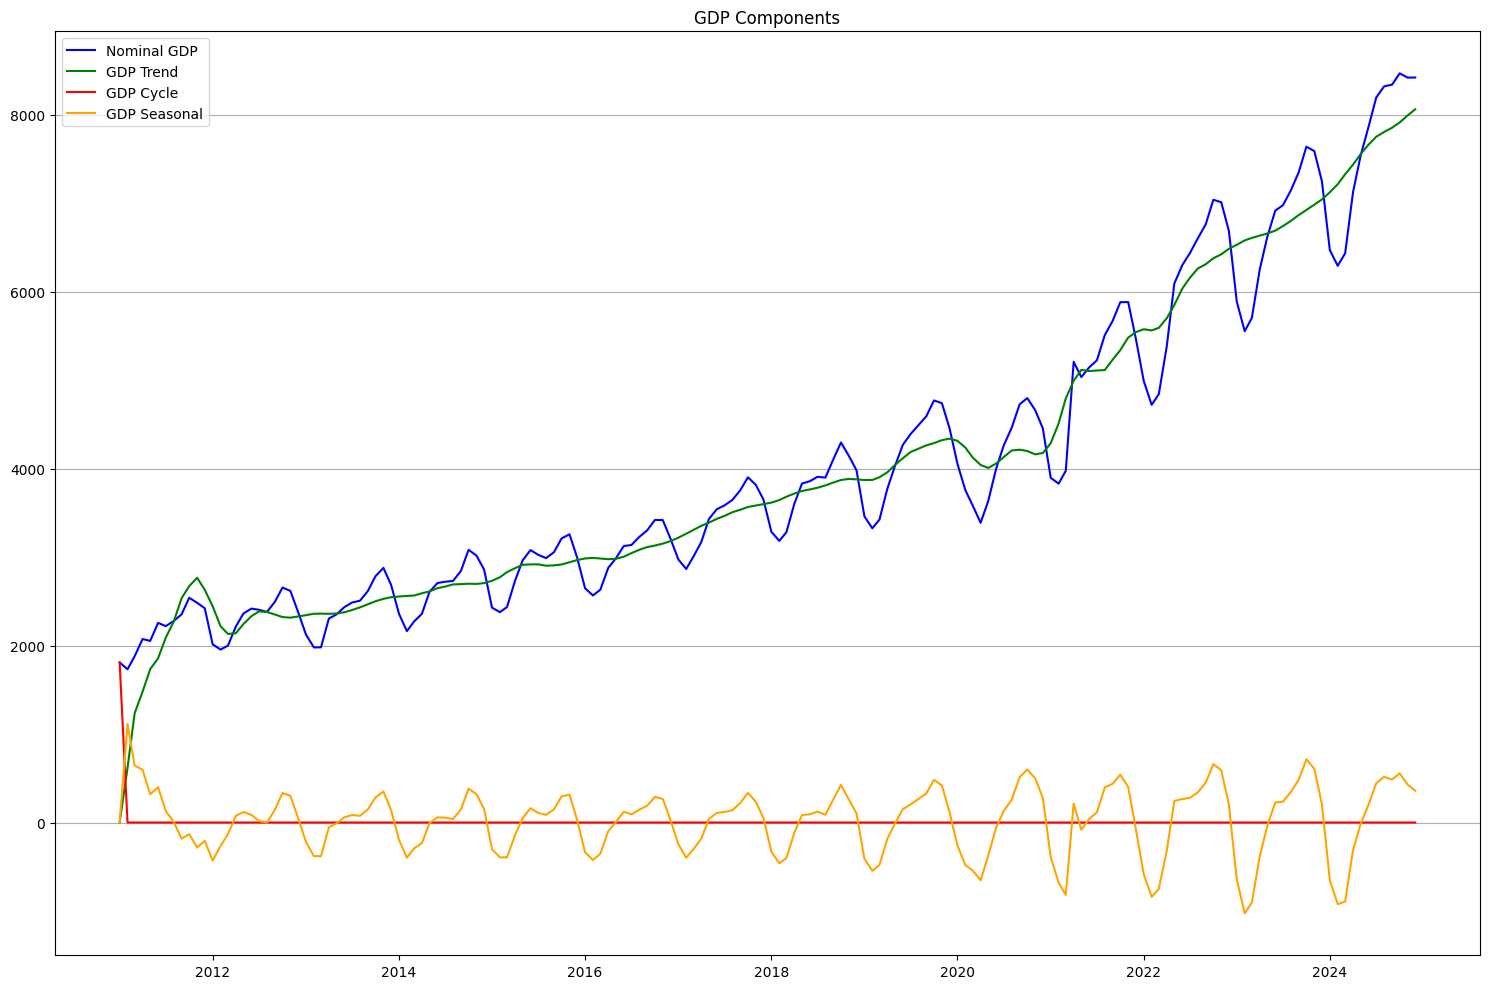

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.plot(df.index, df['GDP_at_market_prices_monthly'], label='Nominal GDP', color='blue')
plt.plot(df.index, df['KF_trend'], label='GDP Trend', color='green')
plt.plot(df.index, df['KF_cycle'], label='GDP Cycle', color='red')
plt.plot(df.index, df['KF_seasonal'], label='GDP Seasonal', color='orange')

plt.title('GDP Components')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.grid(False, axis='x')

plt.savefig('../images/GDP_components.png', dpi=600)
plt.savefig('../images/GDP_components.svg', dpi=600)
plt.show()


# Hodrick-Prescott Filter


## **TODO**

Ask NBG Specialists how'd they describe booom/bust cycles during last decade. *OR* use ISET's business/consumer sentiment index.

Cannot quite work with HP filter without it.

In [9]:
cycle, trend = hpfilter(df['GDP_at_market_prices_monthly'], lamb=14400)

df['HP_trend'] = trend
df['HP_cycle'] = cycle

In [10]:
cycle = df['HP_cycle'].values
peaks, _   = find_peaks(cycle)
troughs, _= find_peaks(-cycle)

df['is_peak']   = False
df['is_trough'] = False
df.iloc[peaks,   df.columns.get_loc('is_peak')]   = True
df.iloc[troughs, df.columns.get_loc('is_trough')] = True



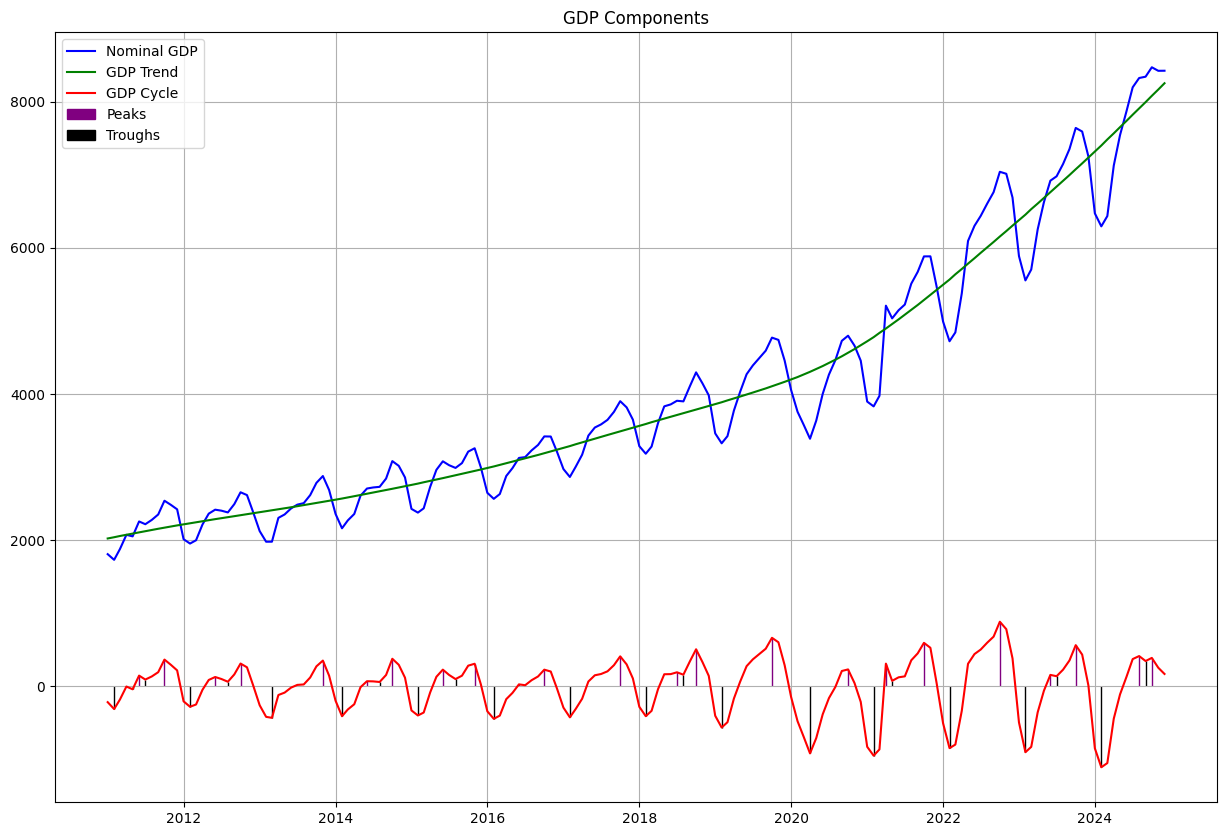

In [11]:
plt.figure(figsize=(15,10))
plt.plot(df.index, df['GDP_at_market_prices_monthly'], label='Nominal GDP', color='blue')
plt.plot(df.index, df['HP_trend'], label='GDP Trend', color='green')
plt.plot(df.index, df['HP_cycle'], label='GDP Cycle', color='red')
# Highlight peaks and troughs
plt.fill_between(df.index, df['HP_cycle'], 
                where=df['is_peak'],
                color='purple', alpha=1, label='Peaks')
plt.fill_between(df.index, df['HP_cycle'],
                where=df['is_trough'], 
                color='black', alpha=1, label='Troughs')
plt.title('GDP Components')
plt.legend()
plt.grid(True)

# Stumpy -- Matrix Profiling

In [12]:
dates = df.index
y_gdp = df['GDP_at_market_prices_monthly'].values
dates = df.index


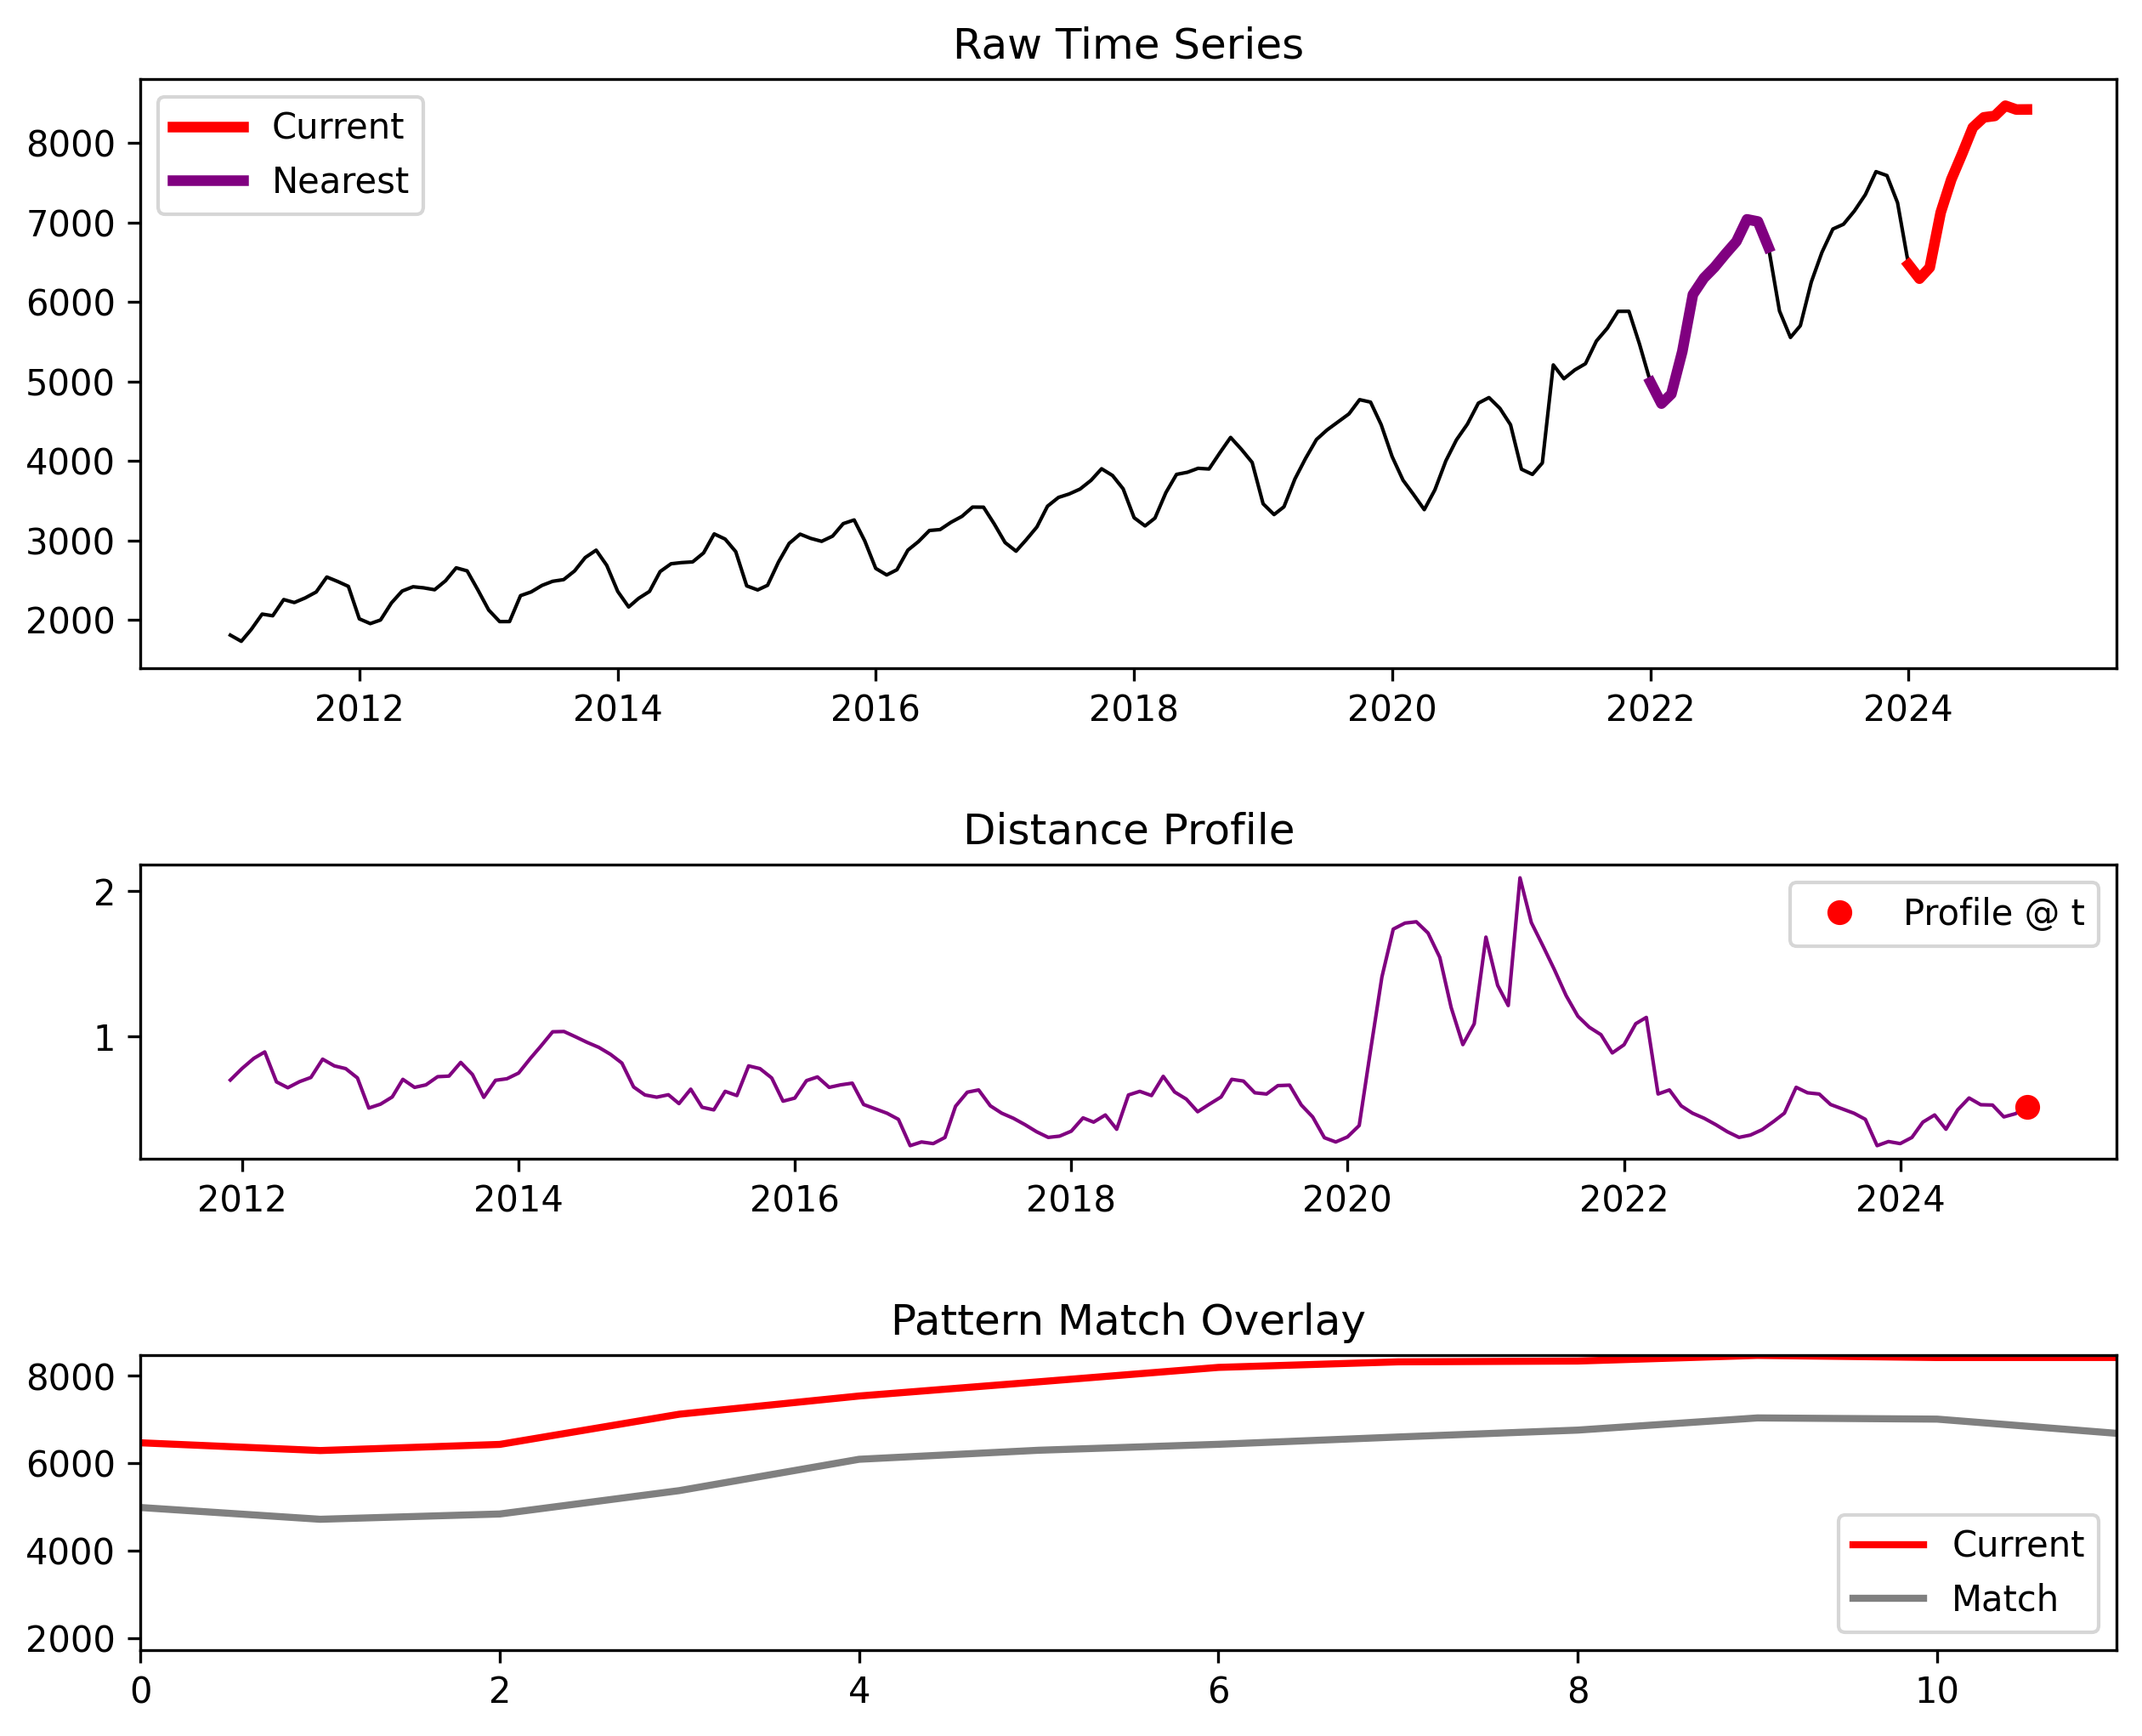

In [13]:
m = 12  # Window size for subsequences, This is 1 year
matrix_profile = stumpy.stump(y, m)
distances = matrix_profile[:, 0]  # Distance profile 
matches = matrix_profile[:, 1].astype(int)  # Nearest neighbor indices

# Set up figure with 3 subplots
fig, (ax_timeseries, ax_profile, ax_patterns) = plt.subplots(
    3, 1, 
    figsize=(10, 8),
    gridspec_kw={'height_ratios': [2, 1, 1]},
    dpi=300
)
plt.subplots_adjust(hspace=0.5)

# Time series plot
ax_timeseries.plot(dates, y, color='black', lw=1)
current_window, = ax_timeseries.plot([], [], color='red', lw=3, label='Current Window') 
matching_window, = ax_timeseries.plot([], [], color='purple', lw=3, label='Best Match')
ax_timeseries.set_title('Time Series Data')
ax_timeseries.legend()

# Distance profile plot
ax_profile.plot(dates[m-1:], distances, color='purple', lw=1)
current_point, = ax_profile.plot([], [], 'ro', label='Current Position')
ax_profile.set_title('Matrix Profile')
ax_profile.legend()

# Pattern comparison plot
ax_patterns.set_xlim(0, m-1)
ax_patterns.set_ylim(y.min(), y.max())
current_pattern, = ax_patterns.plot([], [], color='red', lw=2, label='Current Pattern')
matching_pattern, = ax_patterns.plot([], [], color='gray', lw=2, label='Matching Pattern')
ax_patterns.set_title('Pattern Comparison')
ax_patterns.legend()

def init_animation():
    """Initialize empty animation"""
    lines = [current_window, matching_window, current_point, 
            current_pattern, matching_pattern]
    for line in lines:
        line.set_data([], [])
    return lines

def update_frame(frame):
    """Update animation for each frame"""
    if frame < m-1:
        return init_animation()
        
    # Calculate indices for current and matching windows
    t = frame - (m-1)
    curr_start, curr_end = t, t + m
    match_start = matches[t]
    match_end = match_start + m
    
    # Update time series highlights
    current_window.set_data(dates[curr_start:curr_end], y[curr_start:curr_end])
    matching_window.set_data(dates[match_start:match_end], y[match_start:match_end])
    
    # Update profile marker
    current_point.set_data([dates[frame]], [distances[t]])
    
    # Update pattern overlay
    x_pattern = np.arange(m)
    current_pattern.set_data(x_pattern, y[curr_start:curr_end])
    matching_pattern.set_data(x_pattern, y[match_start:match_end])
    
    return [current_window, matching_window, current_point, 
            current_pattern, matching_pattern]

# Create and save animation
anim = animation.FuncAnimation(
    fig, update_frame,
    frames=len(dates),
    init_func=init_animation,
    blit=True,
    interval=150
)

anim.save('../images/matrix_profile_1D.gif', writer=PillowWriter(fps=10))

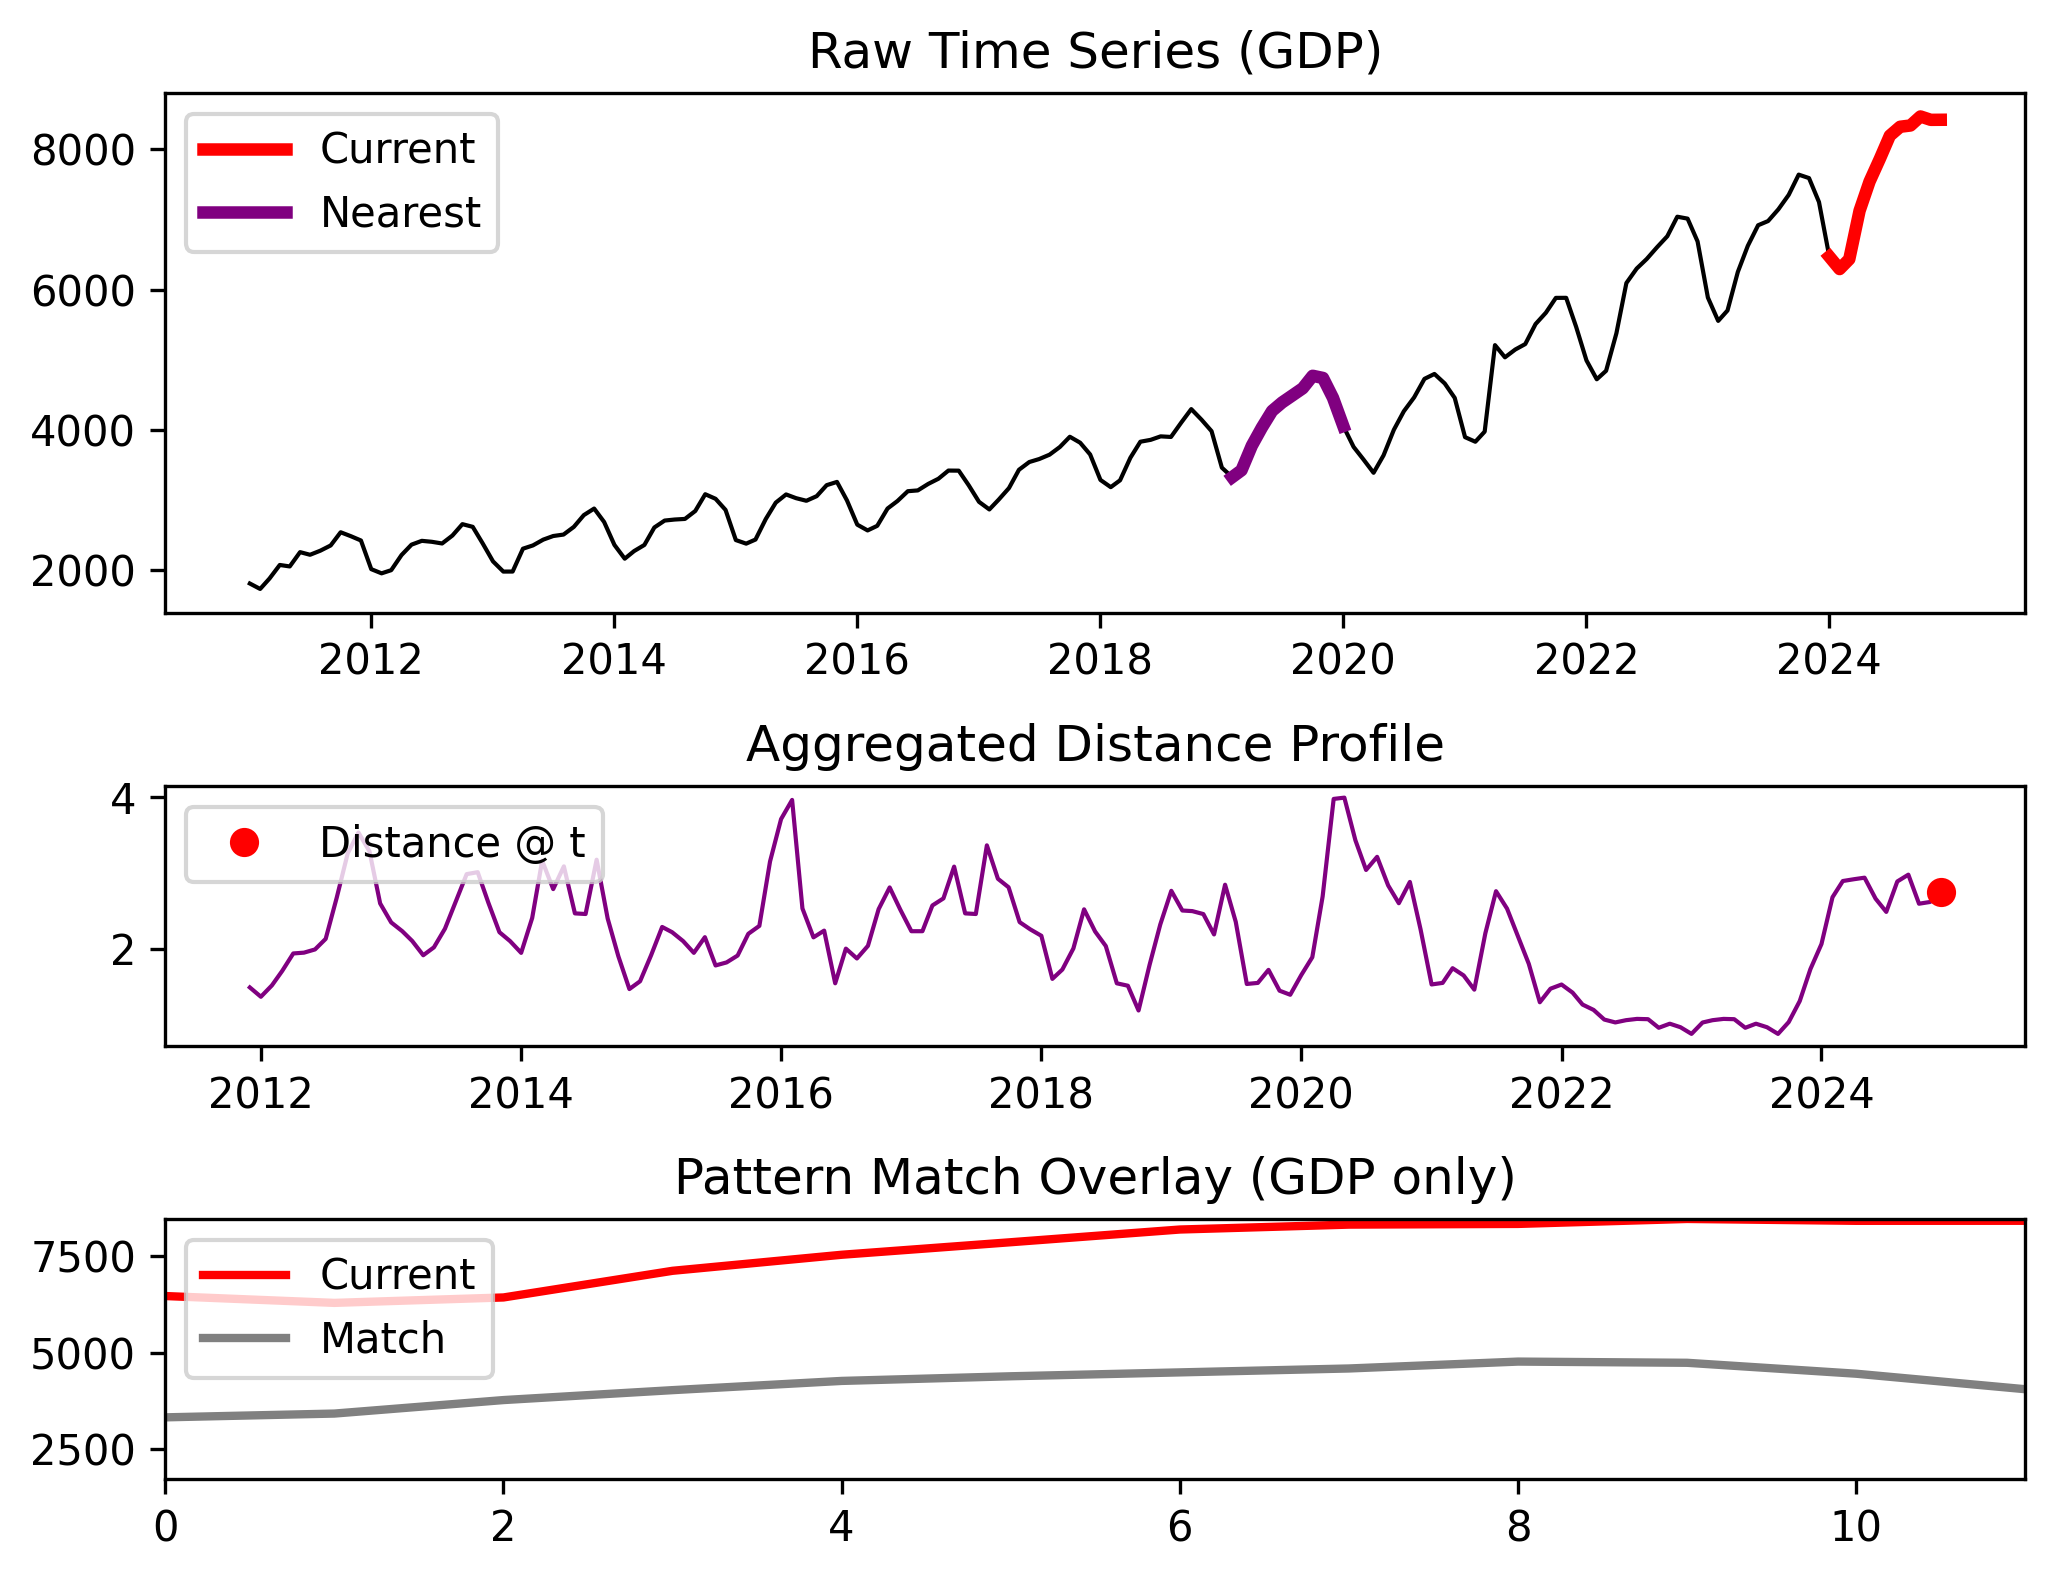

In [ ]:
y_gdp = df['GDP_at_market_prices_monthly'].values
T = len(dates)

# Features we want to analyze
features = [
    'NEER (Dec-2010=100)',
    'Real Effective Exchange Rate - Index (Dec-10=100)',
]
m = 12  # window size

# Get data into right shape and compute matrix profile
X_raw = df[features].values.T  # shape (5, T)
P, I = stumpy.mstump(X_raw, m)  # P, I have shape (5, T-m+1)
dist_profile = np.linalg.norm(P, axis=0)  
dim_min = np.argmin(P, axis=0)
neighbor_idx = I[dim_min, np.arange(P.shape[1])]

valid_dates = dates[m-1:]  # dates for profile plot

# Make the figure with 3 subplots
fig, (ax_raw, ax_dist, ax_ol) = plt.subplots(
    3, 1, figsize=(8, 6),
    gridspec_kw={"height_ratios": [2, 1, 1]},
    dpi=300
)
plt.subplots_adjust(hspace=0.5)

# Top plot - raw GDP data
ax_raw.plot(dates, y_gdp, color="black", lw=1)
cur_raw, = ax_raw.plot([], [], color="red", lw=3, label="Current")
mat_raw, = ax_raw.plot([], [], color="purple", lw=3, label="Nearest")
ax_raw.set_title("Raw Time Series (GDP)")
ax_raw.legend(loc="upper left")

# Middle plot - distance profile
ax_dist.plot(valid_dates, dist_profile, color="purple", lw=1)
dot, = ax_dist.plot([], [], "ro", label="Distance @ t")
ax_dist.set_title("Aggregated Distance Profile")
ax_dist.legend(loc="upper left")

# Bottom plot - pattern matching
ax_ol.set_xlim(0, m-1)
ax_ol.set_ylim(y_gdp.min(), y_gdp.max())
cur_ol, = ax_ol.plot([], [], color="red", lw=2, label="Current")
mat_ol, = ax_ol.plot([], [], color="gray", lw=2, label="Match")
ax_ol.set_title("Pattern Match Overlay (GDP only)")
ax_ol.legend(loc="upper left")

# Animation setup
def init():
    """Initialize empty animation"""
    lines = [cur_raw, mat_raw, dot, cur_ol, mat_ol]
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    """Update animation for each frame"""
    if frame < m-1 or frame >= m-1 + len(dist_profile):
        return init()
    
    t = frame - (m-1)
    i0, i1 = t, t + m
    j0, j1 = neighbor_idx[t], neighbor_idx[t] + m
    
    # Update the plots
    cur_raw.set_data(dates[i0:i1], y_gdp[i0:i1])
    mat_raw.set_data(dates[j0:j1], y_gdp[j0:j1])
    dot.set_data([valid_dates[t]], [dist_profile[t]])
    
    xs = np.arange(m)
    cur_ol.set_data(xs, y_gdp[i0:i1])
    mat_ol.set_data(xs, y_gdp[j0:j1])
    
    return cur_raw, mat_raw, dot, cur_ol, mat_ol

# Create and save animation
ani = animation.FuncAnimation(
    fig, update, frames=len(dates),
    init_func=init, blit=True, interval=20
)
ani.save("../images/matrix_profile_multidim_full.gif", writer=PillowWriter(fps=10))